# Capstone 3
## Deep Learning for Amazon Rainforest Monitoring
## STEP 2: Model

In [1]:
# Importing FastAI libraries for deep learning tasks
from fastai.vision import *
from fastai.vision.all import *

# Pathlib for easy path operations
from pathlib import Path

# Zipfile for working with zip archives
import zipfile

# OS for operating system dependent functionality
import os

# OpenCV for image processing
import cv2

# Tqdm for progress bars during loops
from tqdm import tqdm

# Shutil for file operations like copying
import shutil

# Pandas for data manipulation and analysis
import pandas as pd

# NumPy for numerical operations on arrays
import numpy as np

# Collections for Counter, which is a dict subclass for counting hashable objects
from collections import Counter

# Scikit-learn for various machine learning utilities
from sklearn.preprocessing import MultiLabelBinarizer  # for one-hot encoding of multi-labels
from sklearn.utils.class_weight import compute_sample_weight  # for computing class weights
from sklearn.model_selection import train_test_split  # for splitting the dataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score  # for evaluating the model

# TensorFlow and Keras for building and training neural network models
import tensorflow as tf
from tensorflow.keras.models import Sequential  # Sequential model API
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation  # Different layers for model
from tensorflow.keras.optimizers.legacy import Adam  # Optimizer for training
from tensorflow.keras.losses import *  # Different loss functions
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint  # Callbacks for training

# Matplotlib for plotting and visualization
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns  # Seaborn for statistical data visualization
import matplotlib.image as mpimg  # For loading images for visualization

# Importing warnings to suppress warnings
import warnings
warnings.filterwarnings('ignore')  # Ignoring any warnings that arise


/Applications/anaconda3/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Applications/anaconda3/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.8.dylib
  Referenced from: <BE0CCD9A-269A-30E2-A23C-DA45E89EBB1F> /Applications/anaconda3/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Applications/anaconda3/lib/python3.10/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/Applications/anaconda3/lib/python3.10/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/Applications/anaconda3/lib/python3.10/lib-dynload/../../libjpeg.8.dylib' (no such file), '/Applications/anaconda3/bin/../lib/libjpeg.8.dylib' (no such file), '/usr/local/lib/libjpeg.8.dylib' (no such file), '/usr/lib/libjpeg.8.dylib' (no such file, not in dyld cache)
  warn(f"Failed to load image Python extension: {e}")


### A. Processing Tags/Labels

This code essentially reads in a dataset of images with associated tags, splits the tags into lists, one-hot encodes these tags, and constructs a DataFrame with the paths to the dehazed versions of these images. 

The Dataframe **processed_df** includes the full paths to images alongside their one-hot encoded tags.

In [2]:
# Read the CSV file containing image names and associated tags into a pandas DataFrame
labels_df = pd.read_csv('/Users/daiannestarr/Desktop/Springboard/Capstone3/data/planet/planet/train_classes.csv')

# The 'tags' column contains space-separated tags; this line splits the tags into a list of tags
labels_df['tags'] = labels_df['tags'].apply(lambda x: x.split(' ')) 

# Initialize the MultiLabelBinarizer which will transform the list of tags into a one-hot encoded format
mlb = MultiLabelBinarizer()

# Transform the list of tags into a one-hot encoded matrix where each column corresponds to a tag
labels_encoded = mlb.fit_transform(labels_df['tags'])

# Retrieve the list of class names that the binarizer has learned (i.e., the unique tags)
classes = mlb.classes_ 

# Create a new DataFrame from the one-hot encoded tags with columns named after the tags
labels_encoded_df = pd.DataFrame(labels_encoded, columns=classes)

# Define the directory where the dehazed images are stored
dehazed_image_dir = '/Users/daiannestarr/Desktop/Springboard/Capstone3/data/planet/planet/train-jpg-unhazed/'

# Create a new column in the DataFrame that contains the full path to the dehazed images
labels_df['path'] = labels_df['image_name'].apply(lambda x: os.path.join(dehazed_image_dir, x + '.jpg'))

# Concatenate the DataFrame containing the image paths with the DataFrame of one-hot encoded tags
processed_df = pd.concat([labels_df['path'], labels_encoded_df], axis=1)


In [3]:
processed_df.head()

,path,agriculture,artisinal_mine,bare_ground,blooming,blow_down,clear,cloudy,conventional_mine,cultivation,habitation,haze,partly_cloudy,primary,road,selective_logging,slash_burn,water
0,/Users/daiannestarr/Desktop/Springboard/Capstone3/data/planet/planet/train-jpg-unhazed/train_0.jpg,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
1,/Users/daiannestarr/Desktop/Springboard/Capstone3/data/planet/planet/train-jpg-unhazed/train_1.jpg,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1
2,/Users/daiannestarr/Desktop/Springboard/Capstone3/data/planet/planet/train-jpg-unhazed/train_2.jpg,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
3,/Users/daiannestarr/Desktop/Springboard/Capstone3/data/planet/planet/train-jpg-unhazed/train_3.jpg,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,/Users/daiannestarr/Desktop/Springboard/Capstone3/data/planet/planet/train-jpg-unhazed/train_4.jpg,1,0,0,0,0,1,0,0,0,1,0,0,1,1,0,0,0


The code below prepares the labels and image paths for later use in training a machine learning model. 

It also computes the weights for each sample to be used during training to address potential class imbalance. This means that classes with fewer samples will have a larger impact on the loss function during training, helping to prevent the model from becoming biased toward more frequent classes.

In [4]:
# Removing the 'path' column from the DataFrame and retrieving the values of the remaining columns, which are the one-hot encoded labels
labels = processed_df.drop(columns=['path']).values

# Extracting the 'path' column from the DataFrame and converting it into a list of image file paths
image_paths = processed_df['path'].tolist()

# Function call computes the sample weights based on the class distribution in the labels
sample_weights = compute_sample_weight(class_weight='balanced', y=labels)

## B. Splitting data

This block of code is performing a two-step split of the data:
* First, it splits the original dataset into training and validation sets. 
* Then, it takes the validation set and splits it again to create a test set, resulting in three distinct sets of data for training, validation, and testing. 

The resetting of indexes ensures that the indices of the train, validate, and test datasets are in a standard consecutive order starting from 0, which is helpful for data handling and referencing during model training and evaluation.

In [5]:
# Split the data into train and validate dataframes, in which the latter correspond to 40% of the total images
train_df, validate_df = train_test_split(processed_df, test_size=0.4, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

# Split the previous validation dataframe further on, in two equal size dataframes for validation and testing
validate_df, test_df = train_test_split(validate_df, test_size=0.5, random_state=42)
validate_df = validate_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

The purpose of these operations is to handle the classification tasks where each image might have multiple labels, and to ensure that the classes are balanced in terms of their representation in the training process. 

By calculating the sample weights, the model is informed about the importance of each sample based on the frequency of its class, which can improve model performance especially when some classes are underrepresented.

In [6]:
# Define lists of tags corresponding to different categories of labels in the dataset
weather_tags = ['clear', 'partly_cloudy', 'cloudy', 'haze']  # Weather-related tags
land_tags = ['primary', 'water', 'bare_ground', 'agriculture', 'habitation']  # Land cover types
activity_tags = ['road', 'cultivation', 'slash_burn', 'conventional_mine', 'artisinal_mine', 'selective_logging']  # Human activities
phenomenon_tags = ['blooming', 'blow_down']  # Natural phenomena

# Extract label data from processed_df for each category based on the defined tags
weather_labels = processed_df[weather_tags].values  # Weather labels as a np array
land_labels = processed_df[land_tags].values  # Land labels as a np array
activity_labels = processed_df[activity_tags].values  # Activity labels as a np array
phenomenon_labels = processed_df[phenomenon_tags].values  # Phenomenon labels as a np array

# Compute sample weights for each label category to handle class imbalance.
sample_weights_weather = compute_sample_weight('balanced', weather_labels)  # Weights for weather labels
sample_weights_land = compute_sample_weight('balanced', land_labels)  # Weights for land labels
sample_weights_activity = compute_sample_weight('balanced', activity_labels)  # Weights for activity labels
sample_weights_phenomenon = compute_sample_weight('balanced', phenomenon_labels)  # Weights for phenomenon labels

### C. Creating generators

The code below defines a custom data generator class named CustomDataGenerator that inherits from tf.keras.utils.Sequence. 

This class is used to feed data to a Keras model in batches during training or evaluation, which is especially useful when working with large datasets that do not fit into memory. 

In [7]:
class CustomDataGenerator(tf.keras.utils.Sequence):

    # Constructor of the class with initialization of necessary variables.
    def __init__(self, dataframe, image_paths, labels, sample_weights, batch_size=32, target_size=(128, 128), shuffle=True, augmentations=None):
        # Storing provided parameters as class members.
        self.dataframe = dataframe  # DataFrame containing image paths and labels.
        self.image_paths = image_paths  # List of file paths for images.
        self.labels = labels  # Labels for the images.
        self.sample_weights = sample_weights  # Weights for each sample, used during training.
        self.batch_size = batch_size  # Number of images to process in a batch.
        self.target_size = target_size  # Target size to which images will be resized.
        self.shuffle = shuffle  # Whether to shuffle data after each epoch.
        self.augmentations = augmentations  # Image augmentation methods.
        self.indexes = np.arange(len(self.image_paths))  # Array of indices corresponding to images.
        self.on_epoch_end()  # Method called at the end of each epoch.

    # Method to load and preprocess an image given its file path.
    def load_image(self, path):
        img = cv2.imread(path)  # Load image.
        img = cv2.resize(img, self.target_size)  # Resize image.
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert color format.
        img = img / 255.0  # Normalize pixel values.
        return img  # Return the processed image.
    
    # Method to get the number of batches per epoch.
    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))  # Calculate and return the number of batches.

    # Method to generate data for a given batch index.
    def __getitem__(self, index):
        # Calculate the indexes of the batch
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        # Initialize arrays for the batch data and labels
        X = np.empty((self.batch_size, *self.target_size, 3), dtype=np.float32)
        y = np.empty((self.batch_size, self.labels.shape[1]), dtype=np.float32)
        # Generate the batch data and labels
        for i, idx in enumerate(batch_indexes):
            X[i,] = self.load_image(self.image_paths[idx])  # Load and preprocess the image.
            y[i,] = self.labels[idx]  # Get the corresponding label.
        # Return the batch data and labels
        return X, y

    # Method called at the end of each epoch, shuffling the indexes if necessary.
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)  # Shuffle the order of the image indexes.

    # Method to generate the batch data (X).
    def __generate_X(self, batch_paths):
        X = np.empty((len(batch_paths), *self.target_size, 3))  # Initialize the array for batch data.
        for i, path in enumerate(batch_paths):
            img = cv2.imread(path)  # Load the image.
            img = cv2.resize(img, self.target_size)  # Resize the image.
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert the color format.
            img = img / 255.0  # Normalize the pixel values.
            X[i,] = img  # Assign the processed image to the batch data array.
        return X  # Return the batch data.

### D. Creating model

The code below is a function for constructing a convolutional neural network (CNN) model using Keras' Sequential API, which is appropriate for a stack of layers where each layer has exactly one input tensor and one output tensor.

The model consists of three convolutional blocks, each with convolutional layers followed by batch normalization, ReLU activation, max-pooling, and dropout. 

The convolutional layers extract features from the input images, while the max-pooling layers reduce dimensionality, and dropout layers reduce overfitting. 

After the convolutional blocks, the model flattens the output and passes it through dense layers, with the final layer having a sigmoid activation function suitable for multi-label classification. 

The model is then returned for compilation and training.

In [8]:
# Model building function that defines the architecture of a convolutional neural network.
def build_model(input_shape, num_classes):
    model = Sequential([
        # First convolutional layer with 32 filters and a kernel size of 3x3.
        # 'padding=same' means that the output size is the same as the input size due to padding
        Conv2D(32, (3, 3), padding='same', input_shape=input_shape),
        BatchNormalization(),  # Normalizes the activations of the previous layer at each batch
        Activation('relu'),  # ReLU activation function
        MaxPooling2D(pool_size=(2, 2)),  # Pooling layer to reduce the spatial dimensions
        Dropout(0.25),  # Dropout layer to prevent overfitting by dropping out 25% of the neurons

        # Second convolutional layer with 64 filters and a kernel size of 3x3
        Conv2D(64, (3, 3), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        # Another convolutional layer with the same characteristics to increase the depth
        Conv2D(64, (3, 3), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),  # Increased dropout for further regularization

        # Third convolutional layer with 128 filters.
        Conv2D(128, (3, 3), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        # Increasing the depth with another convolutional layer with 128 filters
        Conv2D(128, (3, 3), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        # Flattening the 3D output to 1D before feeding it to the fully connected layers
        Flatten(),
        # Fully connected layer with 1024 neurons
        Dense(1024),
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.5),  # Increasing dropout to 50% for the fully connected layer
        # Output layer with a number of neurons equal to the number of classes, using the sigmoid activation function
        # Sigmoid is used for multi-label classification to predict the probability of each class independently
        Dense(num_classes, activation='sigmoid')
    ])
    
    return model

This block of code is creating and compiling four separate CNN models using TensorFlow's Keras API. Each model is designed to predict a different subset of classes based on the type of tags (weather, land, activity, phenomenon). The models use binary cross-entropy as their loss function, which is suitable for multi-label classification tasks, and track the 'accuracy' metric during training.

In [9]:
model_weather = build_model(input_shape=(128, 128, 3), num_classes=len(weather_tags))
model_land = build_model(input_shape=(128, 128, 3), num_classes=len(land_tags))
model_activity = build_model(input_shape=(128, 128, 3), num_classes=len(activity_tags))
model_phenomenon = build_model(input_shape=(128, 128, 3), num_classes=len(phenomenon_tags))

model_weather.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
model_land.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
model_activity.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
model_phenomenon.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [10]:
# Arrays of labels for each category of tags are extracted from train_df
weather_labels_np = train_df[weather_tags].values
land_labels_np = train_df[land_tags].values
activity_labels_np = train_df[activity_tags].values
phenomenon_labels_np = train_df[phenomenon_tags].values

# Number of samples that will be propagated through the network in one forward/backward pass
batch_size = 32

# The number of complete passes through the training dataset
epochs = 50

# Callbacks outside of the fit_model function to be reused
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train generator for weather labels
train_generator_weather = CustomDataGenerator(
    dataframe=train_df,
    image_paths=train_df['path'].values,
    labels=train_df[weather_tags].values,
    sample_weights=sample_weights_weather,
    batch_size=batch_size,
    shuffle=True,
    target_size=(128, 128)
)

# Train generator for land labels
train_generator_land = CustomDataGenerator(
    dataframe=train_df,
    image_paths=train_df['path'].values,
    labels=train_df[land_tags].values, 
    sample_weights=sample_weights_land,
    batch_size=batch_size,
    shuffle=True,
    target_size=(128, 128) 
)

# Train generator for activity labels
train_generator_activity = CustomDataGenerator(
    dataframe=train_df,
    image_paths=train_df['path'].values,
    labels=train_df[activity_tags].values,
    sample_weights=sample_weights_activity,
    batch_size=batch_size,
    shuffle=True,
    target_size=(128, 128)
)

# Train generator for phenomenon labels
train_generator_phenomenon = CustomDataGenerator(
    dataframe=train_df,
    image_paths=train_df['path'].values,
    labels=train_df[phenomenon_tags].values,
    sample_weights=sample_weights_phenomenon,
    batch_size=batch_size,
    shuffle=True,
    target_size=(128, 128)
)

# Validation generator for weather labels
validate_generator_weather = CustomDataGenerator(
    dataframe=validate_df,
    image_paths=validate_df['path'].values,
    labels=validate_df[weather_tags].values,
    sample_weights=sample_weights_weather,
    batch_size=batch_size,
    shuffle=True,
    target_size=(128, 128)
)

# Validation generator for land labels
validate_generator_land = CustomDataGenerator(
    dataframe=validate_df,
    image_paths=validate_df['path'].values,
    labels=validate_df[land_tags].values, 
    sample_weights=sample_weights_land,
    batch_size=batch_size,
    shuffle=True,
    target_size=(128, 128)
)

# Validation generator for activity labels
validate_generator_activity = CustomDataGenerator(
    dataframe=validate_df,
    image_paths=validate_df['path'].values,
    labels=validate_df[activity_tags].values,
    sample_weights=sample_weights_activity,
    batch_size=batch_size,
    shuffle=True,
    target_size=(128, 128)
)

# Validation generator for phenomenon labels
validate_generator_phenomenon = CustomDataGenerator(
    dataframe=validate_df,
    image_paths=validate_df['path'].values,
    labels=validate_df[phenomenon_tags].values,
    sample_weights=sample_weights_phenomenon,
    batch_size=batch_size,
    shuffle=True,
    target_size=(128, 128)
)

# Define a generic model fitting function
def fit_model(model, train_gen, val_gen, epochs, checkpoint_suffix):
    model_checkpoint = ModelCheckpoint(checkpoint_suffix, save_best_only=True)
    history = model.fit(
        train_gen,
        epochs=epochs,
        validation_data=val_gen,
        callbacks=[early_stopping, model_checkpoint]
    )
    return history

# Fit the models for each tag group
history_weather = fit_model(model_weather, train_generator_weather, validate_generator_weather, epochs, 'best_model_weather.h5')
history_land = fit_model(model_land, train_generator_land, validate_generator_land, epochs, 'best_model_land.h5')
history_activity = fit_model(model_activity, train_generator_activity, validate_generator_activity, epochs, 'best_model_activity.h5')
history_phenomenon = fit_model(model_phenomenon, train_generator_phenomenon, validate_generator_phenomenon, epochs, 'best_model_phenomenon.h5')

Epoch 1/50
759/759 [==============================] - 502s 661ms/step - loss: 0.1328 - accuracy: 0.9004 - val_loss: 0.1570 - val_accuracy: 0.8555
Epoch 2/50
759/759 [==============================] - 520s 685ms/step - loss: 0.0938 - accuracy: 0.9254 - val_loss: 0.0763 - val_accuracy: 0.9447
Epoch 3/50
759/759 [==============================] - 538s 709ms/step - loss: 0.0829 - accuracy: 0.9349 - val_loss: 0.1153 - val_accuracy: 0.9216
Epoch 4/50
759/759 [==============================] - 566s 746ms/step - loss: 0.0776 - accuracy: 0.9384 - val_loss: 0.1174 - val_accuracy: 0.9024
Epoch 5/50
759/759 [==============================] - 560s 738ms/step - loss: 0.0702 - accuracy: 0.9439 - val_loss: 0.0847 - val_accuracy: 0.9300
Epoch 6/50
759/759 [==============================] - 615s 810ms/step - loss: 0.0664 - accuracy: 0.9464 - val_loss: 0.0532 - val_accuracy: 0.9579
Epoch 7/50
759/759 [==============================] - 650s 857ms/step - loss: 0.0649 - accuracy: 0.9478 - val_loss: 0.0613 -

### E. Model Validation

In [11]:
# organizing the training and validation metrics from the history objects of four different trained models into dictionaries for easy access

metrics_weather = {
    'train_loss': history_weather.history['loss'],
    'train_accuracy': history_weather.history['accuracy'],
    'val_loss': history_weather.history['val_loss'],
    'val_accuracy': history_weather.history['val_accuracy']}

metrics_land = {
    'train_loss': history_land.history['loss'],
    'train_accuracy': history_land.history['accuracy'],
    'val_loss': history_land.history['val_loss'],
    'val_accuracy': history_land.history['val_accuracy']}

metrics_activity = {
    'train_loss': history_activity.history['loss'],
    'train_accuracy': history_activity.history['accuracy'],
    'val_loss': history_activity.history['val_loss'],
    'val_accuracy': history_activity.history['val_accuracy']}

metrics_phenomenon = {
    'train_loss': history_phenomenon.history['loss'],
    'train_accuracy': history_phenomenon.history['accuracy'],
    'val_loss': history_phenomenon.history['val_loss'],
    'val_accuracy': history_phenomenon.history['val_accuracy']}

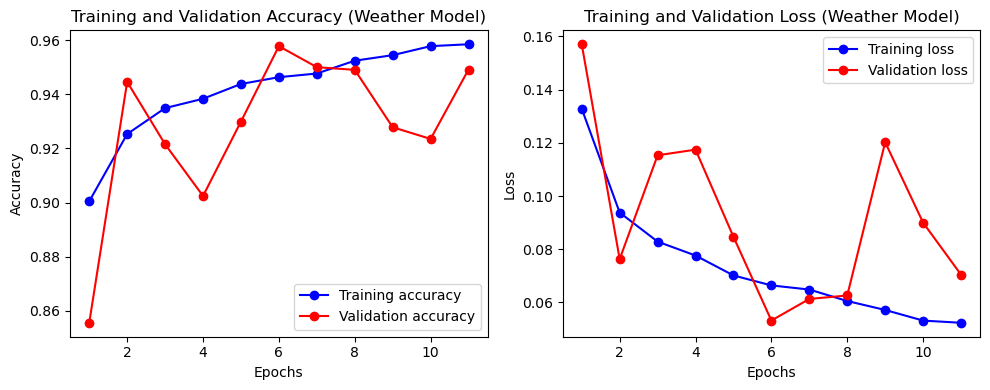

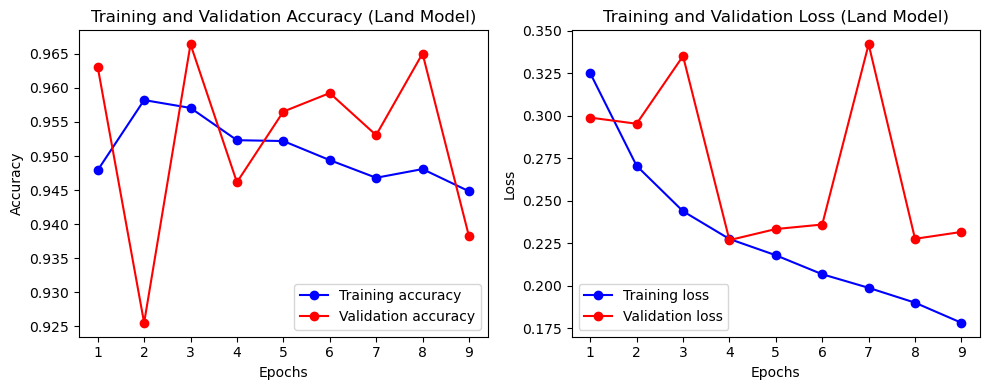

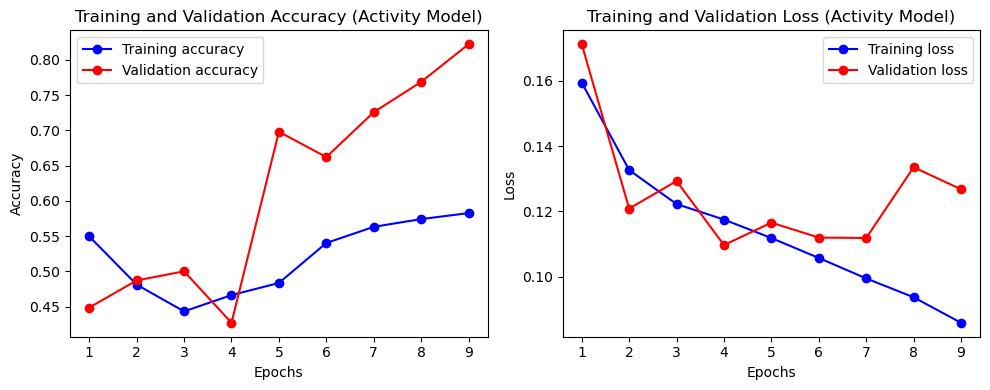

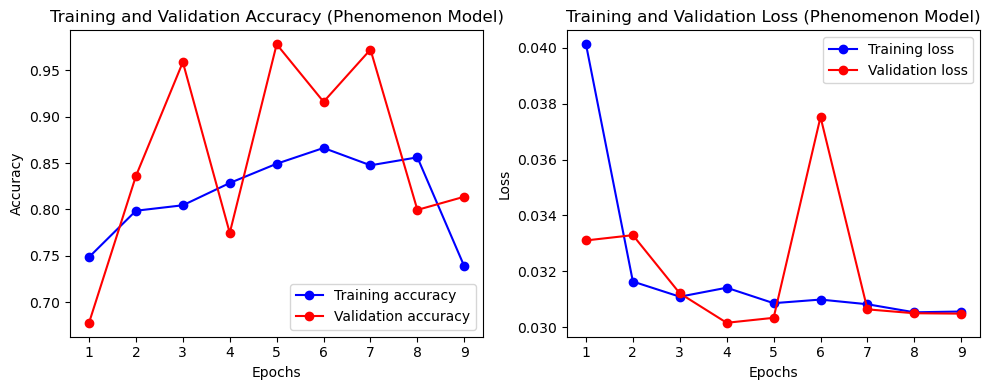

In [12]:
#Plotting the metrics 

def plot_metrics(history, title=''):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(10, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation accuracy')
    plt.title('Training and Validation Accuracy ' + title)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
    plt.title('Training and Validation Loss ' + title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_metrics(history_weather, title='(Weather Model)')
plot_metrics(history_land, title='(Land Model)')
plot_metrics(history_activity, title='(Activity Model)')
plot_metrics(history_phenomenon, title='(Phenomenon Model)')

**Weather Model Metrics**:

* The weather model's training accuracy rose notably from 90.04% to 95.86%, showing the model's growing proficiency in making correct predictions.
* Training loss decreased steadily from 0.1328 to 0.0524, indicating it learned well from the training data. 
* However, the validation loss fluctuated, suggesting variability in the model's generalization to new data. While validation accuracy generally increased to a peak of 95.79%, the observed fluctuations point to potential overfitting or the need for model tuning to ensure stable performance across various data sets.

**Land Model Metrics**:

* The land model's high training accuracy, consistently above 0.94, suggests the model fits the training data well.
* The training loss illustrates a positive downward trend, starting high at 0.3251 and dropping to 0.1783, indicating that the model is effectively reducing error in its predictions as it learns. 
* However, the validation loss presents a more complex picture with noticeable fluctuations and an upward trend towards the end of the training epochs, hinting at potential overfitting. The model might be too tailored to the training data, reducing its ability to generalize to new, unseen data.
* The validation accuracy mirrors this pattern of fluctuation but maintains high performance, peaking at an impressive 0.9664. Despite these peaks, the variability suggests that the model's ability to generalize may be inconsistent across different data subsets within the validation set.

**Activity Model Metrics**:
* The activity model's learning curve indicates substantial progress in model performance, with training loss decreasing notably, suggesting that the model is learning to classify the complex activity labels more effectively. 
* Although the model's accuracy started relatively low, it shows a promising increase, pointing towards an improved ability to correctly predict activity labels as it processes more data. 
* Validation results show variability but overall improvement, indicating better generalization to unseen data by the end of the training process. However, the fluctuations in validation loss hint at potential issues with model stability that could be addressed with further tuning.


**Phenomenon Model Metrics**:
* The phenomenon model displayed a commendable performance right from the outset, with a low training loss that decreased further, indicative of the model's proficiency in reducing error over time. 
* Training accuracy experienced a rise, showcasing the model's capability to classify correctly during training sessions, despite minor fluctuations which are normal in the training process.
* In terms of validation, the loss remained minimal and showed a decrease, which is a strong sign of the model's ability to generalize to new, unseen data. 
* The validation accuracy, while generally high, did exhibit some variability. However, reaching a peak accuracy of 97.80% is noteworthy and suggests that the model could effectively identify the correct phenomena in most cases. 
* The variability in validation accuracy could point towards model sensitivity to specific data or potential overfitting, warranting further investigation and possible model refinement.

### F. Testing the model

In [14]:
def preprocess_image(image_path, target_size=(128, 128)):
    # Load image
    img = cv2.imread(image_path)
    # Resize image
    img = cv2.resize(img, target_size)
    # Convert image color to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Normalize image
    img = img / 255.0
    return img

# Extract image paths from test_df
test_image_paths = test_df['path'].tolist()

# Preprocess images
test_images = np.array([preprocess_image(path) for path in test_image_paths])
test_data = test_images

In [15]:
# Run predictions on test data
predictions_weather = model_weather.predict(test_data)
predictions_land = m
odel_land.predict(test_data)
predictions_activity = model_activity.predict(test_data)
predictions_phenomenon = model_phenomenon.predict(test_data)

253/253 [==============================] - 39s 152ms/step


### G. Model Evaluation

In [50]:
weather_tags = ['clear', 'partly_cloudy', 'cloudy', 'haze']
land_tags = ['primary', 'water', 'bare_ground', 'agriculture', 'habitation']
activity_tags = ['road', 'cultivation', 'slash_burn', 'conventional_mine', 'artisinal_mine', 'selective_logging']
phenomenon_tags = ['blooming', 'blow_down']

# Combine all tags into a single list
all_tags_list = weather_tags + land_tags + activity_tags + phenomenon_tags

# Fit the MultiLabelBinarizer on the combined list of tags
mlb = MultiLabelBinarizer()
mlb.fit([[tag] for tag in all_tags_list])

# Now mlb.classes_ contains all unique classes in the order they are one-hot encoded
all_classes = mlb.classes_

# Create a dictionary that maps class names to their indices
unified_class_indices = {class_name: index for index, class_name in enumerate(all_classes)}

# Now you can get the indices for each tag group
weather_class_indices = [unified_class_indices[tag] for tag in weather_tags]
land_class_indices = [unified_class_indices[tag] for tag in land_tags]
activity_class_indices = [unified_class_indices[tag] for tag in activity_tags]
phenomenon_class_indices = [unified_class_indices[tag] for tag in phenomenon_tags]

# Create an empty array for each model's aligned predictions
num_samples = predictions_activity.shape[0]  # Assuming all prediction arrays have the same number of samples
num_classes = 17  # Total number of classes across all subsets

# Initialize aligned predictions with zeros or another placeholder
aligned_preds_weather = np.zeros((num_samples, num_classes))
aligned_preds_land = np.zeros((num_samples, num_classes))
aligned_preds_phenomenon = np.zeros((num_samples, num_classes))
aligned_preds_activity = np.zeros((num_samples, num_classes))

# Fill in the predictions for each model
aligned_preds_weather[:, weather_class_indices] = predictions_weather
aligned_preds_land[:, land_class_indices] = predictions_land
aligned_preds_phenomenon[:, phenomenon_class_indices] = predictions_phenomenon
aligned_preds_activity[:, activity_class_indices] = predictions_activity

# Combine the predictions
combined_predictions = (aligned_preds_weather + aligned_preds_land +
                        aligned_preds_activity + aligned_preds_phenomenon)


# Binarize the prediction
binary_prediction = (combined_predictions  > 0.5).astype(float)

In [53]:
# Define the evaluate_metrics function
def evaluate_metrics(binary_prediction, true_labels):
    # Calculate metrics
    accuracy = accuracy_score(true_labels, binary_prediction)
    precision = precision_score(true_labels, binary_prediction, average='micro')
    recall = recall_score(true_labels, binary_prediction, average='micro')
    f1 = f1_score(true_labels, binary_prediction, average='micro')
    
    return accuracy, precision, recall, f1

ensemble_accuracy, ensemble_precision, ensemble_recall, ensemble_f1 = evaluate_metrics(binary_prediction, test_labels)
print(f'Ensemble Model Accuracy: {ensemble_accuracy}')
print(f'Ensemble Model Precision: {ensemble_precision}')
print(f'Ensemble Model Recall: {ensemble_recall}')
print(f'Ensemble Model F1 Score: {ensemble_f1}')

Ensemble Model Accuracy: 0.5679347826086957
Ensemble Model Precision: 0.9267661388550548
Ensemble Model Recall: 0.7886417620384366
Ensemble Model F1 Score: 0.8521430738001353


**Ensemble Model Accuracy (56.79%)** : This is the proportion of the total number of predictions that were correct. It's moderate, meaning that more than half of the model's predictions were accurate, but there is still a significant portion that is incorrect. In this model, this is due to class imbalance. 

**In the context of a multi-label classification task where class distribution is imbalanced, accuracy can sometimes be misleading. It simply reflects the proportion of the total number of correct predictions, without indicating how well the model performs on each individual class. Therefore, precision, recall, and the F1 score are more informative for evaluating the performance of the model.*** 

**Ensemble Model Precision (92.67%)**: This is very high, which means that among all the labels the model predicted as present, most of them were actually correct. In a multi-label context, this indicates that there is a low rate of false positives across all labels.

**Ensemble Model Recall (78.86%)**: This is also quite high, showing that the model is capable of identifying a large proportion of relevant instances across all labels. However, it's not as high as the precision, which suggests that the model is more conservative in its predictions, possibly missing out on some true positives (false negatives).

**Ensemble Model F1 Score (85.21%)**: Given that the F1 score balances precision and recall, this high score suggests that the model has a robust performance across all labels in your multi-label setup. It manages to maintain a balance between not mislabeling negative instances as positive (high precision) and not missing out on too many positive instances (high recall), despite the imbalanced nature of the dataset.

**Overall, these metrics suggest that the model performs well on the multi-label classification task, especially in terms of precision and F1 score. It manages to correctly predict a high number of instances for each label, and when it does predict, it is right most of the time.** 